<a href="https://colab.research.google.com/github/AisIzmailova/AisIzmailova_Practice_Notebooks/blob/master/DL_Transfer_Learning_with_Tensorflow_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning

##Part 1: Feature extraction

Transfer learning is leveraging a working model's existing architecture and
learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems  similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data
to our own, then we can adapt those patterns to our own data.


Different types of transfer learning:
- **As is** transfer learning - using an existing model with no changes.
- **Feature extraction** - use the prelearned patterns of an existing model (e.g. Efficientnet trained on Imagenet) and adjust the output layer for our own problem.
- **Fine-tuning** - use prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers).


In [9]:
#Use same food data but just 10 percent
# !wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import numpy as np
import random
import datetime

#Unzip the data
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [13]:
#Walk through 10 classes of food image data
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 2 directories and 0 images in 10_food_classes_10_percent.
There are 10 directories and 0 images in 10_food_classes_10_percent/train.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza.
There are

In [14]:
#Set up train and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [15]:
#Get the class names
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [16]:
#Preprocess data (normalize pixel values)
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [17]:
#Define parameters
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

In [18]:
#Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                            batch_size=BATCH_SIZE,
                                            target_size=IMAGE_SHAPE,
                                            class_mode="sparse",
                                            seed=42)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMAGE_SHAPE,
                                               class_mode="sparse",
                                               seed=42)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


###Setting up callbacks

Callbacks are extra functionality you can add to your models to be performed during or after training.
Some of the most popular callbacks:
- Tracking experiments with the TensorflowBoard callback
- Model checkpoint with the ModelCheckpoint callback
- Stopping the model from training (before it trains too long and overfits) with the EarlyStopping callback

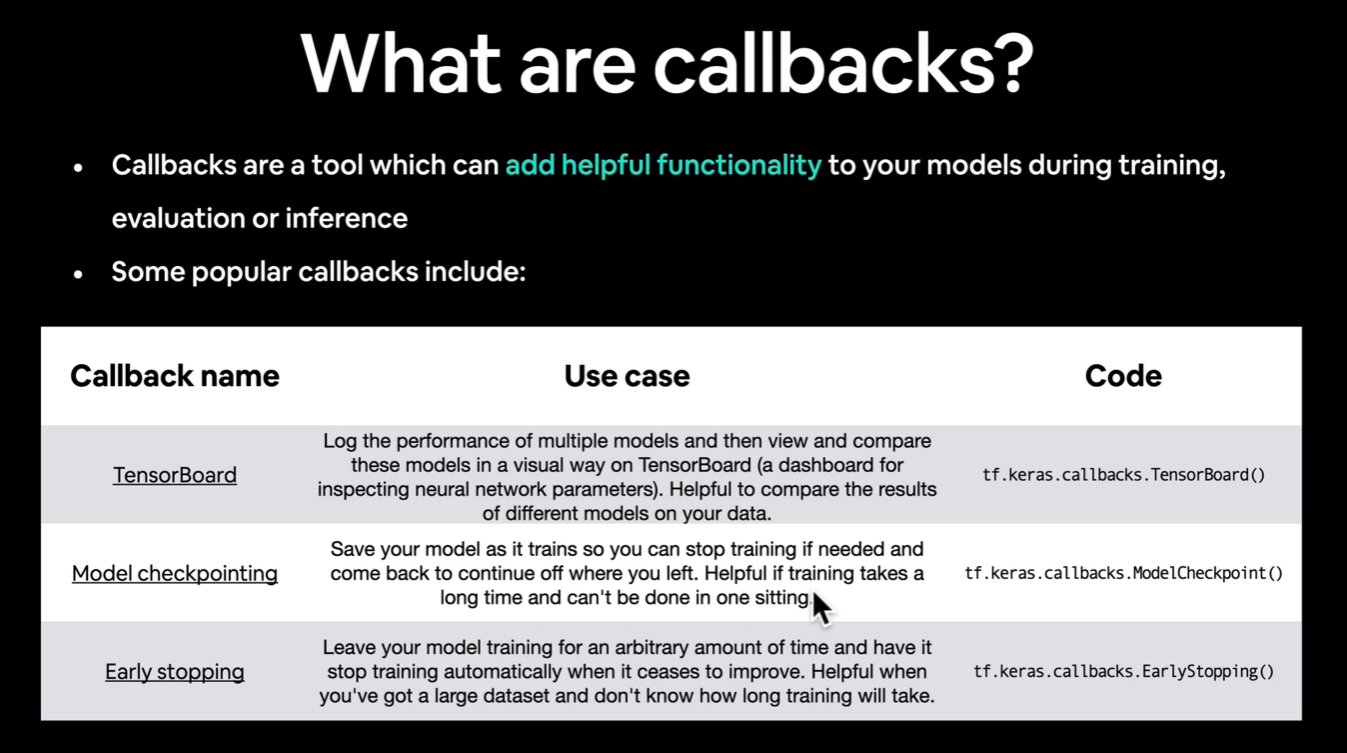

In [19]:
#Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

###Create transfer learning model using TensorflowHub (https://www.tensorflow.org/hub)

In the past we used tensorflow to create our own models layer by layer from scratch.
Now we are going to do similar process, except the majority of our model's layers are going to come from TensorflowHub.
We can access pretrained models on: https://tfhub.dev/
Read: paperswithcode.com for recent research papers
Resnet_v2_50 model : https://www.kaggle.com/models/google/resnet-v2/frameworks/tensorFlow2/variations/50-feature-vector/versions/1
Efficientnet model: https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/tensorFlow2/variations/b0-feature-vector/versions/1


In [20]:
#Choose two pretrained models from tfhub
resnet_url="https://www.kaggle.com/models/google/resnet-v2/frameworks/tensorFlow2/variations/50-feature-vector/versions/1"
efficientnet_url="https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/tensorFlow2/variations/b0-feature-vector/versions/1"

In [21]:
#import dependencies
import tensorflow_hub as hub
from tensorflow.keras import layers

#Create create_model() function
def create_model(model_url, num_classes):
    """
    Takes a Tensorflow Hub url and creates a Keras Sequential model.
    Args:
    model_url (str): a tensorflow hub feature extraction url
    num_classes (int): number of output neurons in the output layer, should be equal to number of target classes, default 10.
    Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes putput neurons.
    """
    #Download the pretrained model and save it as Keras layer
    feature_extraction_layer = hub.KerasLayer(model_url,
                                       trainable=False,
                                       name="feature_extraction_layer",
                                       input_shape=IMAGE_SHAPE+(3,))
    #Create our model
    model=tf.keras.Sequential([
        feature_extraction_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])
    return model

In [22]:
#Create ResNet Tensorflow Hub Feature Extraction model
resnet_model = create_model(model_url=resnet_url,num_classes=train_data.num_classes)

#Compile the model
resnet_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

#Fit the model
history_resnet = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="resnet_v2_50")])

Saving TensorBoard log files to: tensorflow_hub/resnet_v2_50/20231223-223609
Epoch 1/5
24/24 [==============================] - 23s 611ms/step - loss: 1.9025 - accuracy: 0.3773 - val_loss: 1.1333 - val_accuracy: 0.6436
Epoch 2/5
24/24 [==============================] - 11s 459ms/step - loss: 0.9105 - accuracy: 0.7320 - val_loss: 0.8100 - val_accuracy: 0.7428
Epoch 3/5
24/24 [==============================] - 11s 481ms/step - loss: 0.6220 - accuracy: 0.8267 - val_loss: 0.7324 - val_accuracy: 0.7632
Epoch 4/5
24/24 [==============================] - 11s 484ms/step - loss: 0.4775 - accuracy: 0.8787 - val_loss: 0.6903 - val_accuracy: 0.7784
Epoch 5/5
24/24 [==============================] - 10s 431ms/step - loss: 0.3853 - accuracy: 0.9160 - val_loss: 0.6603 - val_accuracy: 0.7868


In [23]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training any validation metrics.
  """
  loss= history.history["loss"]
  val_loss= history.history["val_loss"]
  accuracy= history.history["accuracy"]
  val_accuracy= history.history["val_accuracy"]
  epochs =range(len(history.history["loss"]))

  #Plot the loss
  plt.figure()
  plt.plot(epochs,loss,  label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()
  #Plot the accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy,  label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

In [24]:
print("Resnet model evaluation: ", resnet_model.evaluate(test_data))

79/79 [==============================] - 12s 152ms/step - loss: 0.6603 - accuracy: 0.7868
Resnet model evaluation:  [0.6602886319160461, 0.7868000268936157]


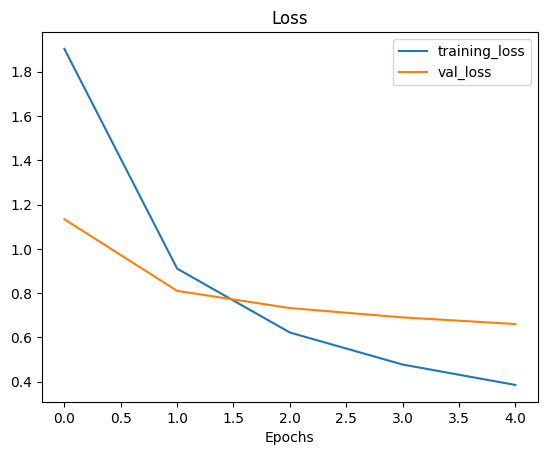

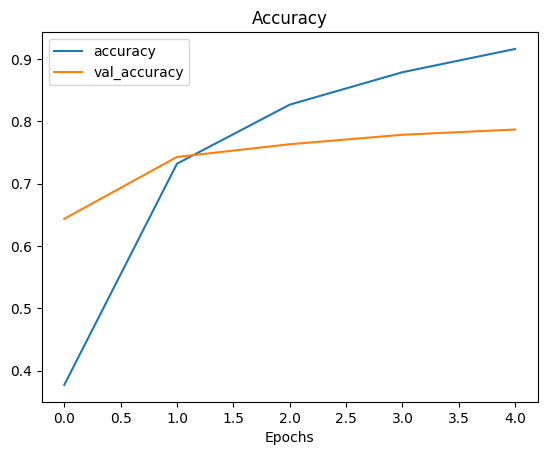

In [25]:
plot_loss_curves(history_resnet)

In [26]:
#Create efficientnet model
efficientnet_model=create_model(model_url=efficientnet_url, num_classes=train_data.num_classes)

#Compile the model
efficientnet_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

#Fit the model
history_efficientnet=efficientnet_model.fit(train_data,
                                            epochs=5,
                                            steps_per_epoch=len(train_data),
                                            validation_data=test_data,
                                            validation_steps=len(test_data),
                                            callbacks=[create_tensorboard_callback("tensorflow_hub","efficientnet")])

Saving TensorBoard log files to: tensorflow_hub/efficientnet/20231223-223802
Epoch 1/5
24/24 [==============================] - 24s 559ms/step - loss: 1.8272 - accuracy: 0.4493 - val_loss: 1.2909 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 10s 447ms/step - loss: 1.0541 - accuracy: 0.7693 - val_loss: 0.8669 - val_accuracy: 0.8224
Epoch 3/5
24/24 [==============================] - 10s 430ms/step - loss: 0.7538 - accuracy: 0.8173 - val_loss: 0.6979 - val_accuracy: 0.8400
Epoch 4/5
24/24 [==============================] - 13s 546ms/step - loss: 0.6051 - accuracy: 0.8560 - val_loss: 0.6149 - val_accuracy: 0.8532
Epoch 5/5
24/24 [==============================] - 10s 446ms/step - loss: 0.5126 - accuracy: 0.8853 - val_loss: 0.5611 - val_accuracy: 0.8616


In [27]:
print("Efficientnet model evaluation: ", efficientnet_model.evaluate(test_data))

79/79 [==============================] - 8s 105ms/step - loss: 0.5611 - accuracy: 0.8616
Efficientnet model evaluation:  [0.5610660910606384, 0.8615999817848206]


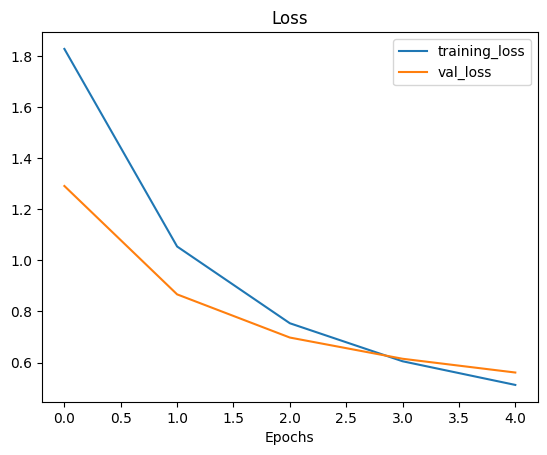

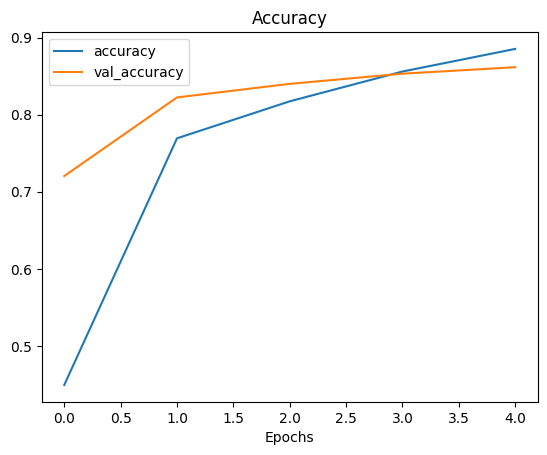

In [28]:
plot_loss_curves(history_efficientnet)

###Comparing our models results using TensorBoard

In [29]:
#Upload dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "Efficientnet_b0 vs. Resnet_v2_50" \
--description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data"\
--one_shot

2023-12-23 22:42:53.922117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 22:42:53.922180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 22:42:53.923485: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 22:42:54.901900: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb